In [1]:
import scipy.signal as ss
import numpy as np
import matplotlib.pyplot as plt

# Some spectrogram techniques

Starting from a spectrogram (or a pwelch), one can build up some signal processing techniques. Consider a test signal of a sinusoidal modulation on noise.

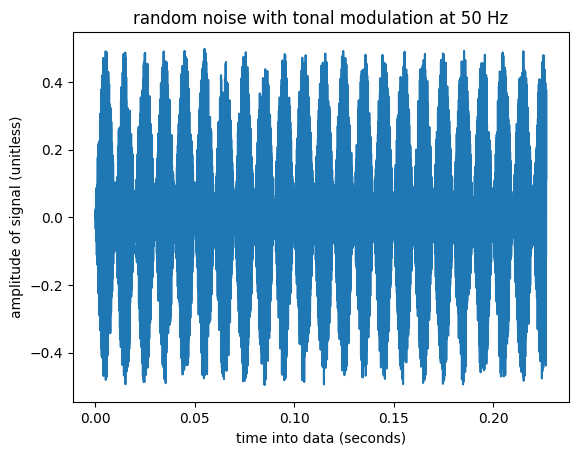

In [2]:
n_sample = 10000
fs = 44100  # sample rate in Hz
f_tonal = 50  # tonal frequency in Hz
data = (np.random.random(n_sample) - 0.5) * np.sin(np.arange(n_sample) * 2.0 * np.pi * f_tonal / fs)
plt.plot(np.arange(n_sample) / fs, data)
plt.xlabel("time into data (seconds)")
plt.ylabel("amplitude of signal (unitless)")
plt.title(f"random noise with tonal modulation at {f_tonal} Hz")
plt.show()

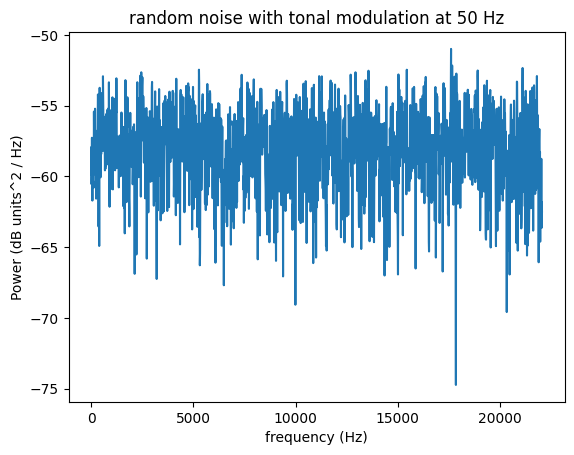

In [3]:
freqs, Pxx = ss.welch(data, fs, "hanning", nperseg=4096, noverlap=2048, detrend=False, scaling="density")
plt.plot(freqs, 10 * np.log10(Pxx))
plt.xlabel("frequency (Hz)")
plt.ylabel("Power (dB units^2 / Hz)")
plt.title(f"random noise with tonal modulation at {f_tonal} Hz")
plt.show()

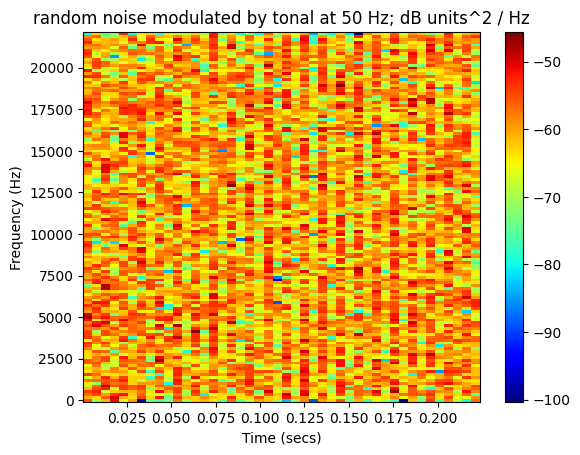

In [4]:
freqs, times, Sxx = ss.spectrogram(data, fs, nperseg=256, detrend=False)
plt.pcolormesh(times, freqs, 10 * np.log10(Sxx), shading="nearest", cmap="jet")
plt.ylabel("Frequency (Hz)")
plt.xlabel("Time (secs)")
plt.title(f"random noise modulated by tonal at {f_tonal} Hz; dB units^2 / Hz")
plt.colorbar()
plt.show()

Notice have the signal has been presented entirely in the time domain, entirely in the frequency domain, and in a spectrogram (which sits in the middle). The 50Hz signal is not easy to pick out in the pwelch, but can be see in the spectrogram.

### Channelisation

The spectrogram allows a form of channelisation by frequency band, called FBE (Frequency Band Extracted) data. Each of the frequency bins can be thought of as a channel at that frequency

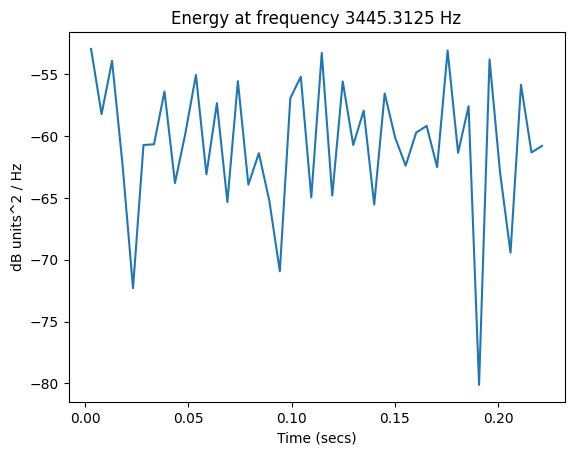

In [5]:
freq_bin = 20
plt.plot(times, 10 * np.log10(Sxx[freq_bin]))
plt.xlabel("Time (secs)")
plt.ylabel("dB units^2 / Hz")
plt.title(f"Energy at frequency {freqs[freq_bin]} Hz")
plt.show()

One can sum various frequency bins to get the FBE data over that frequency range

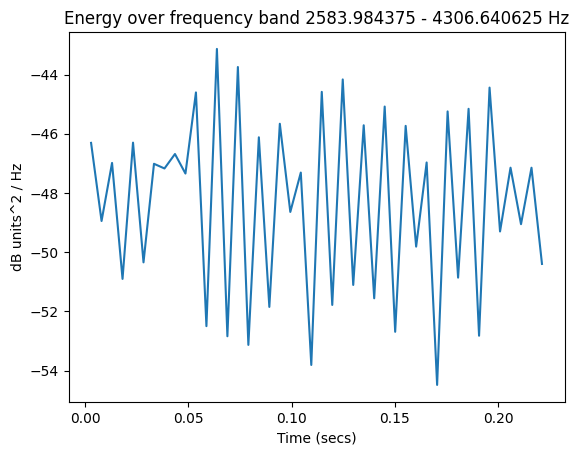

In [6]:
freq_bin_low = 15
freq_bin_hi = 25
plt.plot(times, 10 * np.log10(np.sum(Sxx[freq_bin_low:freq_bin_hi], axis=0)))
plt.xlabel("Time (secs)")
plt.ylabel("dB units^2 / Hz")
plt.title(f"Energy over frequency band {freqs[freq_bin_low]} - {freqs[freq_bin_hi]} Hz")
plt.show()

FBE data can be considered as a time series (sampled in slow time) for further downstream processing.

### DEMON processing

[Detection of Envelope Modulation On Noise (DEMON)](https://acoustics.asn.au/conference_proceedings/AAS2008/papers/p63.pdf) uses the spectrogram to explore behaviour in slow frequency (in particular period behaviour in slow time). The signal model is envelope modulation over a noise like carrier.

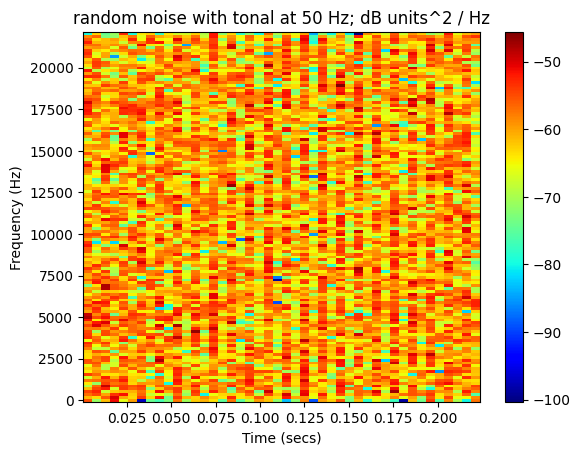

In [7]:
freqs, times, Sxx = ss.spectrogram(data, fs, nperseg=256, detrend=False)
plt.pcolormesh(times, freqs, 10 * np.log10(Sxx), shading="nearest", cmap="jet")
plt.ylabel("Frequency (Hz)")
plt.xlabel("Time (secs)")
plt.title(f"random noise with tonal at {f_tonal} Hz; dB units^2 / Hz")
plt.colorbar()
plt.show()

In [8]:
def demongram(data, **kwargs):
    """ kwargs are the same as the kwargs passed to scipy.signal.spectrogram """
    kwargs["scaling"] = "spectrum"  # force the spectrogram to have a scaling that preserves energy
    fast_freqs, slow_times, Sxx = ss.spectrogram(data, **kwargs)
    sxx = np.sqrt(Sxx)  # due to scaling, this should now have units of amplitude
    Dxx_as_list = []
    slow_fs = 1.0 / np.median(np.diff(slow_times))  # slow time sample rate
    for freq_channel in sxx:
        # set the pwelch to have a single FFT window across all of slow time for this freq_channel (not sure if that is a good idea - may wish to set   
        #     nperseg to be a a configurable constant, so that the DEMON features are always the same length)
        # use the same window as that in the kwargs for the spectrogram (not sure if that is a good idea)
        # set detrend to constant, since there will be a DC offset in freq_channel, since that is the sqrt of an energy profile and hence always > 0
        slow_freqs, Pxx = ss.welch(np.sqrt(freq_channel), fs=slow_fs, window=kwargs.get("window", "hanning"), nperseg=len(freq_channel), detrend="constant", scaling="density")
        Dxx_as_list.append(Pxx)
    return fast_freqs, slow_freqs, np.array(Dxx_as_list)

In [9]:
fast_freqs, slow_freqs, Dxx = demongram(data, fs=fs, nperseg=64, detrend=False)

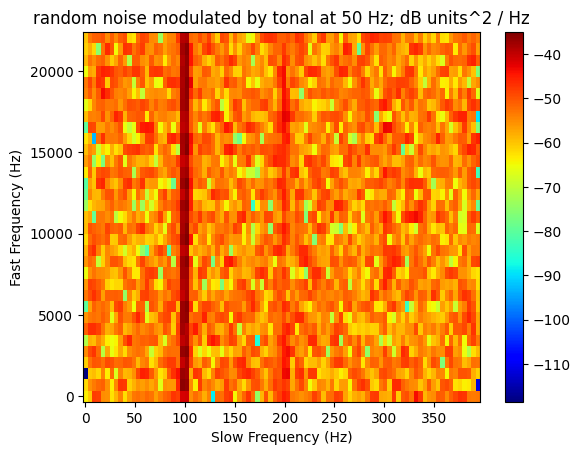

In [10]:
plt.pcolormesh(slow_freqs, fast_freqs, 10 * np.log10(Dxx), shading="nearest", cmap="jet")
plt.ylabel("Fast Frequency (Hz)")
plt.xlabel("Slow Frequency (Hz)")
plt.title(f"random noise modulated by tonal at {f_tonal} Hz; dB units^2 / Hz")
plt.colorbar()
plt.show()

The DEMONgram is able to pick out the modulation on top of the noise at 100Hz. Note that since the slow-time FFT was taken over an energy profile, the 50Hz signal is seen as a 100Hz signal (as expected from a the double angle formula $2 \sin^2(x) = 1 - \cos (2x)$.

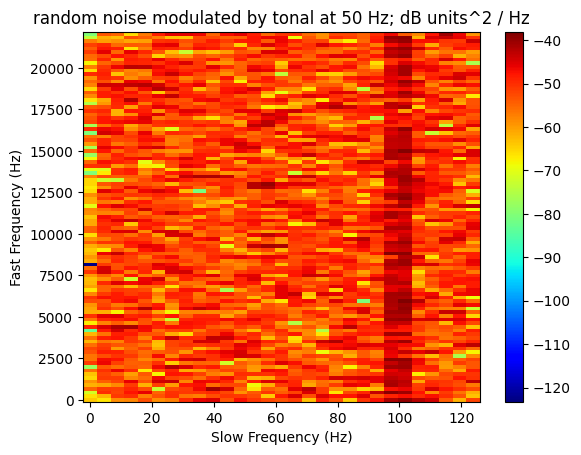

In [11]:
fast_freqs, slow_freqs, Dxx = demongram(data, fs=fs, nperseg=200, detrend=False)
plt.pcolormesh(slow_freqs, fast_freqs, 10 * np.log10(Dxx), shading="nearest", cmap="jet")
plt.ylabel("Fast Frequency (Hz)")
plt.xlabel("Slow Frequency (Hz)")
plt.title(f"random noise modulated by tonal at {f_tonal} Hz; dB units^2 / Hz")
plt.colorbar()
plt.show()

As the FFT length going into the spectrogram becomes larger, the processing gain for the modulation falls. Recall that the FFT length specifies an integration window on the original signal. If that integration window is on the length scale, or is longer, than the modulation period, then the integration window will integrate out the modulation behaviour. This is a part of tuning the FFT length in the spectrogram.

In this case, the DEMONgram has been calculated from the spectrogram. It could also be calculated from the FBE data to give a 1D array result.

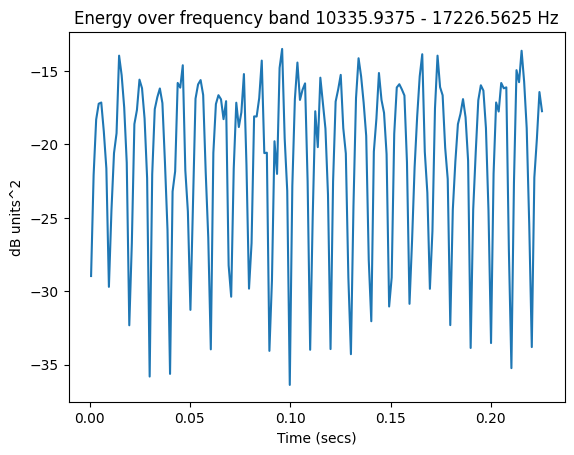

In [12]:
freqs, times, Sxx = ss.spectrogram(data, fs, nperseg=64, detrend=False, scaling="spectrum")
freq_bin_low = 15
freq_bin_hi = 25
fbe = np.sum(Sxx[freq_bin_low:freq_bin_hi], axis=0)

plt.plot(times, 10 * np.log10(fbe))
plt.xlabel("Time (secs)")
plt.ylabel("dB units^2")
plt.title(f"Energy over frequency band {freqs[freq_bin_low]} - {freqs[freq_bin_hi]} Hz")
plt.show()

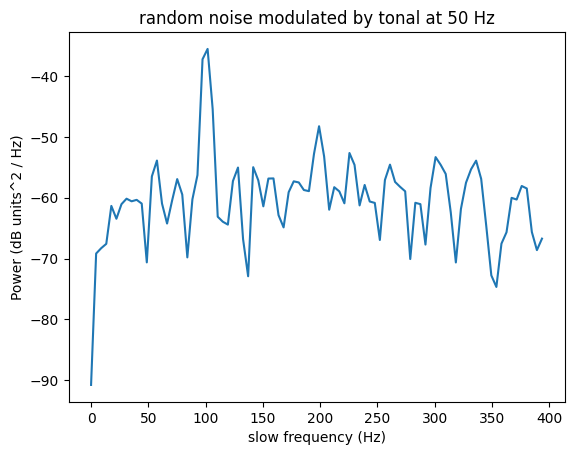

In [13]:
slow_freqs, Pxx = ss.welch(
    np.sqrt(fbe),  # sqrt so that data has units of amplitude
    fs=1.0 / np.median(np.diff(times)),  # work out slow time sample rate from the times array coming out of the spectrogram
    window="hanning",
    nperseg= len(fbe),  # set FFT length to be all the data
    detrend="constant",  # remove DC
    scaling="density"  # ensure output in units^2 / Hz
)
plt.plot(slow_freqs, 10 * np.log10(Pxx))
plt.xlabel("slow frequency (Hz)")
plt.ylabel("Power (dB units^2 / Hz)")
plt.title(f"random noise modulated by tonal at {f_tonal} Hz")
plt.show()

### Cepstrum

The [cepstrum](https://en.wikipedia.org/wiki/Cepstrum) is an additional FFT stage after computing a spectrum (e.g. via a pwelch). It can be useful for clearly idnetifying a number of tightly spaced harmonic spikes in a spectrum, by virtue of the [Fourier transform of a Dirac comb being a Dirac comb](https://en.wikipedia.org/wiki/Dirac_comb), where a comb with spacing $\delta f$ Hz is mapped to a comb with spacing $\frac{1}{\delta f}$ seconds.

Consider a signal with multiple harmonics

In [14]:
n_sample = 10000
fs = 44100  # sample rate in Hz
f_tonal = 1000  # tonal frequency in Hz
n_harmonic = 6
data = (np.random.random(n_sample) - 0.5)
for i_harmonic in range(n_harmonic):
    data += np.sin(np.arange(n_sample) * 2.0 * np.pi * f_tonal * (i_harmonic+1) / fs) / (i_harmonic + 1)

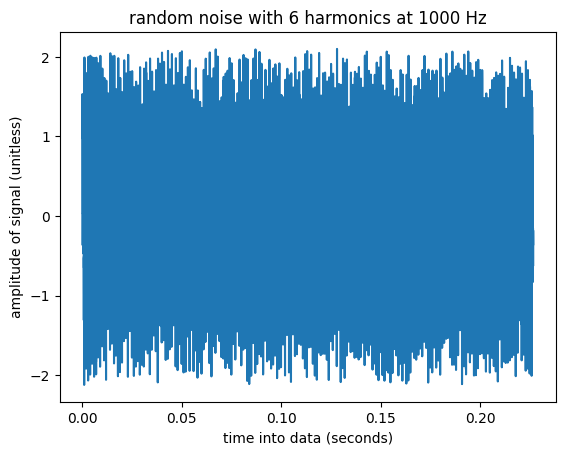

In [15]:
plt.plot(np.arange(n_sample) / fs, data)
plt.xlabel("time into data (seconds)")
plt.ylabel("amplitude of signal (unitless)")
plt.title(f"random noise with {n_harmonic} harmonics at {f_tonal} Hz")
plt.show()

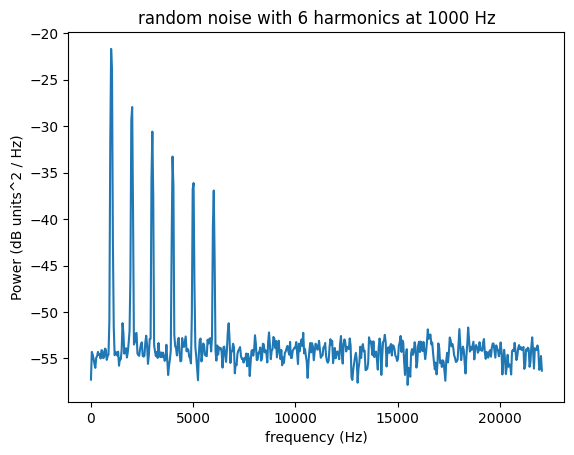

In [16]:
freqs, Pxx = ss.welch(data, fs=fs, window="hanning", nperseg=1028, detrend=False, scaling="density")
plt.plot(freqs, 10 * np.log10(Pxx))
plt.xlabel("frequency (Hz)")
plt.ylabel("Power (dB units^2 / Hz)")
plt.title(f"random noise with {n_harmonic} harmonics at {f_tonal} Hz")
plt.show()

In [17]:
def cepstrum(data, **kwargs):
    """ kwargs are the same as the kwargs passed to scipy.signal.welch """
    freqs, Pxx = ss.welch(data, **kwargs)
    ts = 1.0 / np.median(np.diff(freqs))
    quefrencies, Cxx = ss.welch(np.log(Pxx), fs=ts, window=kwargs.get("window", "hanning"), nperseg=len(Pxx), detrend="constant", scaling="density")
    return quefrencies, Cxx

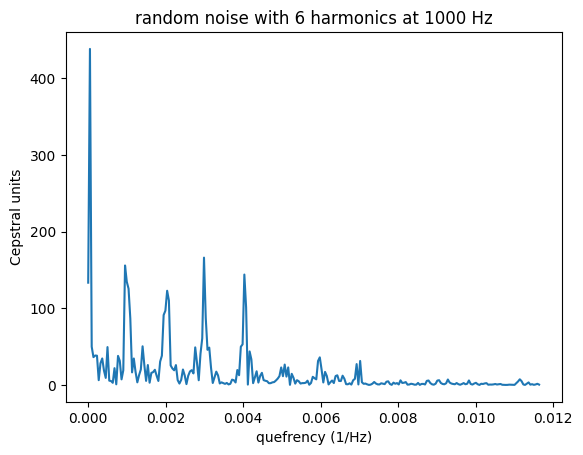

In [18]:
quefrencies, Cxx = cepstrum(data, fs=fs, window="hanning", nperseg=1028, detrend=False, scaling="density")
plt.plot(quefrencies, Cxx)
plt.xlabel("quefrency (1/Hz)")
plt.ylabel("Cepstral units")
plt.title(f"random noise with {n_harmonic} harmonics at {f_tonal} Hz")
plt.show()

The cepstrum shows a number of spikes, all at quefrencies that are a multiple of 0.001 Hz$^{-1}$, corresponding to a harmonic fundamental at 1000 Hz. Whether or not the cepstrum shows the harmonic behaviour more clearly, or it is easier to see in the pwelch used by the cepstrum, is dependent on the data. Sometimes the harmonic behaviour is easier to see in the pwelch, and sometimes it is easier to see in the cepstrum.